In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import cv2
from random import randint
import os
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split
# from models import build_model
from skimage.transform import resize
from losers import combine_loss
from metrics import dice_coef
from helpers import create_dataset_from_tfrecord
from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
from helpers import create_tfrecords, get_reshaper
from tqdm import tqdm_notebook

from util import create_coverage_stratas, get_paths

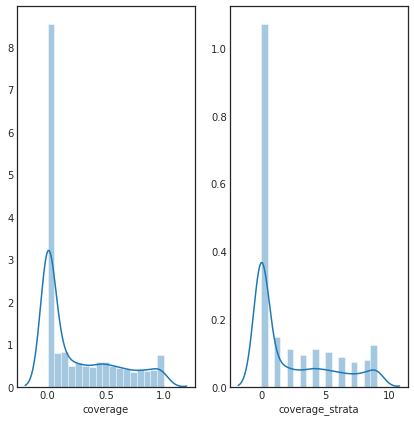

In [3]:
images_salt_stratas = pd.read_csv('stratified_data.csv')

f, ax = plt.subplots(1,2, figsize=(7,7))
sns.distplot(images_salt_stratas['coverage'], ax=ax[0])
sns.distplot(images_salt_stratas['coverage_strata'], ax=ax[1])


In [4]:
images_salt_stratas.head()

,id,mask,img,coverage,coverage_strata
0,bf05a52a6b,./drive/My Drive/tgs/train/masks/bf05a52a6b.png,./drive/My Drive/tgs/train/images/bf05a52a6b.png,0.000196,0
1,bfbea83faa,./drive/My Drive/tgs/train/masks/bfbea83faa.png,./drive/My Drive/tgs/train/images/bfbea83faa.png,0.409960,4
2,bfa7ee102e,./drive/My Drive/tgs/train/masks/bfa7ee102e.png,./drive/My Drive/tgs/train/images/bfa7ee102e.png,0.960396,9
3,bfac8e63cb,./drive/My Drive/tgs/train/masks/bfac8e63cb.png,./drive/My Drive/tgs/train/images/bfac8e63cb.png,0.000000,0
4,bf76c8aff3,./drive/My Drive/tgs/train/masks/bf76c8aff3.png,./drive/My Drive/tgs/train/images/bf76c8aff3.png,0.128223,1


In [0]:
train_index, valid_index = train_test_split(images_salt_stratas.index, test_size=0.2, stratify=images_salt_stratas.coverage_strata, random_state=1337)

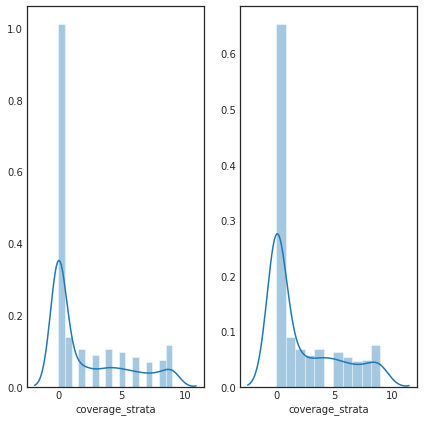

In [6]:
f, ax = plt.subplots(1, 2, figsize=(7,7))
sns.distplot(images_salt_stratas.loc[train_index].coverage_strata, ax=ax[0])
sns.distplot(images_salt_stratas.loc[valid_index].coverage_strata, ax=ax[1])

In [0]:
train_imgs, valid_imgs = train_test_split([(i, m) for i, m in zip(images_salt_stratas['img'].values, images_salt_stratas['mask'].values)], test_size=0.2, stratify=images_salt_stratas.coverage_strata, random_state=1337)

In [8]:
train_imgs[0]

('./drive/My Drive/tgs/train/images/a37249665e.png',
 './drive/My Drive/tgs/train/masks/a37249665e.png')

In [0]:
    create_tfrecords(train_imgs, '/content/drive/My Drive/train_records', [get_reshaper()])
    create_tfrecords(valid_imgs, '/content/drive/My Drive/test_records', [get_reshaper()])

In [0]:
def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    #uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [17]:
input_layer = Input((128, 128, 1))
output_layer = build_model(input_layer, 16)
model = Model(input_layer, output_layer)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

RuntimeError: ignored